# Cloud analysis using CancerModels.Org API
This Jupyter notebook shows how to use CancerModels.Org API for your own analysis using cloud platforms or in your pipelines or study.

## Requirements
#### Packages

In [ ]:
from requests import get, exceptions
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from scipy.stats import ttest_ind

#### Functions/Methods

In [ ]:
def request(link, flag):
  headers = {"Content-Type": "application/json"}
  try:
    if flag :
      response = get(link, headers=headers, stream=True)
    else:
      response = get(link)
    if response.status_code == 200:
      if flag:
        data_list = []
        for chunk in response.iter_content(chunk_size=1024):
          # Process each chunk (e.g., write to a file, parse as JSON, etc.)
          if chunk:
              data = json.loads(chunk)
              data_list.append(data)
        return data_list
      else:
        return response
    else:
        response.raise_for_status()
  except exceptions.RequestException as e:
      print(f"An error occurred: {e}")
      return None

def make_boxplot(normal, gene, tumor_df, ax):
    # Extract normal data for the specific gene and transpose
    df = normal[normal['hgnc_symbol'] == gene].transpose().reset_index()
    df.columns = df.iloc[0]  # Set the first row as column names
    df = df.iloc[1:]  # Remove the header row
    df['type'] = "Normal"  # Add type column
    df = df[['hgnc_symbol', gene, 'type']]  # Keep only relevant columns
    df.columns = ['model_id', 'rnaseq_fpkm', 'type']  # Rename columns

    # Prepare tumor data (ensure no warning by using .copy())
    tumor_df = tumor_df[['model_id', 'rnaseq_fpkm']].copy()
    tumor_df.loc[:, 'type'] = "Tumor"  # Use .loc[] to avoid setting value on a slice

    # Combine normal and tumor data
    combined_df = pd.concat([df, tumor_df])

    # Convert 'rnaseq_fpkm' column to numeric (just in case there are any issues)
    combined_df['rnaseq_fpkm'] = pd.to_numeric(combined_df['rnaseq_fpkm'], errors='coerce')

    # Create the boxplot with hue and palette to avoid future warnings
    sns.boxplot(x='type', y='rnaseq_fpkm', hue='type', data=combined_df, palette="Set2", showfliers=False, ax=ax)
    ax.legend([],[], frameon=False)  # Remove redundant legend

    # Calculate p-value (using t-test for example)
    normal_values = combined_df[combined_df['type'] == 'Normal']['rnaseq_fpkm']
    tumor_values = combined_df[combined_df['type'] == 'Tumor']['rnaseq_fpkm']
    stat, p_value = ttest_ind(normal_values, tumor_values, nan_policy='omit')

    # Add p-value to the plot title if significant
    if p_value < 0.05:
        ax.set_title(f"Normal vs Tumor - {gene} (p < 0.05)", fontsize=10)
    else:
        ax.set_title(f"Normal vs Tumor - {gene} (p = {p_value:.2e})", fontsize=10)

    # Set axis labels
    ax.set_xlabel("Sample Type", fontsize=8)
    ax.set_ylabel("Log transformed RNA-Seq FPKM", fontsize=8)

# This is a helper function to handle potential errors during API calls
def get_data(url, name):
  """
  Fetches data from the provided URL and handles potential errors.

  Args:
    url (str): The URL to fetch data from.
    name (str): The name of the data being fetched (used for logging).

  Returns:
    pd.DataFrame: The data as a Pandas DataFrame.
  """
  df = pd.DataFrame()
  i = 0
  limit = 10000

  # Loop until all data is fetched
  while True:
    new_url = f"{url}&order=sample_id.asc&limit={limit}&offset={i}"
    try:
      response = get(new_url, stream=True)
      # Raise an exception for bad status codes (like 404 or 500)
      response.raise_for_status()
      data = response.json()
      # Handle empty responses
      if not data:
        break
      df = pd.concat([df, pd.DataFrame(data)]).reset_index(drop=True)
    except exceptions.RequestException as e:
      print(f"Error fetching {name} data: {e}")
      break  # Exit loop if error encountered
    except ValueError as e:
      print(f"Error decoding JSON for {name} data: {e}, response: {response.text}")
      break  # Exit loop if JSON decode error encountered

    i += limit
    if len(data) < limit:
      break  # Exit loop if all data has been retrieved
  return df

def get_gene_expression(gene, model_id):
  url = f"{api_path}expression_data_extended?rnaseq_fpkm=not.is.null&source=neq.patient&hgnc_symbol=eq.{gene}&select=model_id,sample_id,hgnc_symbol,rnaseq_fpkm"
  df = get_data(url, gene)
  if df is not None and 'model_id' in df.columns:
    df = df[df['model_id'].isin(model_id)]
    df['rnaseq_fpkm'] = np.log2(df['rnaseq_fpkm'] + 0.001)
  return df

def get_mutation_data(gene, model_id):
  url = f"{api_path}mutation_data_extended?hgnc_symbol=eq.{gene}&source=neq.patient&select=model_id,sample_id,hgnc_symbol,amino_acid_change,consequence,allele_frequency,ref_allele,alt_allele"
  df = get_data(url, gene)
  if df is not None and 'model_id' in df.columns:
    df = df[df['model_id'].isin(model_id)]
  return df

def plot_cancer_system_boxplot(gene, model_metadata):
  expression_data = get_gene_expression(gene, model_metadata.model_id.to_list())
  expression_data = expression_data.merge(model_metadata[['model_id', 'type', 'cancer_system']], on='model_id', how='left')
  plot_wide_boxplot(expression_data, gene)

def plot_wide_boxplot(data, gene, mt=None):
  # Fix for palette warning and tick labels
  sns.set_theme(rc={'figure.figsize':(14, 8)})

  # Create boxplot
  ax = sns.boxplot(data=data, x='cancer_system', y='rnaseq_fpkm', hue='cancer_system', palette='Set3', dodge=False)

  # Rotate the x-axis labels
  ax.tick_params(axis='x', rotation=90)

  # Add title
  if mt is None:
    ax.set_title(f'{gene} Expression Levels Across Cancer Systems', fontsize=16)
  else:
    ax.set_title(f'{gene} Expression Levels Across Cancer Systems for {mt} models', fontsize=16)
  ax.set_xlabel('Cancer System', fontsize=12)
  ax.set_ylabel('Log transformed RNA-Seq FPKM', fontsize=12)

  # Optionally, add gridlines for better readability
  ax.yaxis.grid(True)

  # Show the plot
  plt.tight_layout()
  plt.show()

def plot_cancer_system_boxplot_by_model_type(gene, model_metadata):
  data = get_gene_expression(gene, model_metadata.model_id.to_list())
  data = data.merge(model_metadata[['model_id', 'type', 'cancer_system']], on='model_id', how='left')
  mts = ['PDX', 'organoid', 'cell line']
  for mt in mts:
    df = data[data['type'] == mt]
    plot_wide_boxplot(df, gene, mt)


#### Variables

In [ ]:
api_path = 'https://dev.cancermodels.org/api/'

## API


#### List of endpoints

In [ ]:
list_of_available_endpoints = pd.DataFrame(request(api_path, False).json()['paths'].keys())[0].to_list()
print(list_of_available_endpoints)

['/', '/available_molecular_data_columns', '/biomarker_data_extended', '/biomarker_data_table', '/cell_model', '/cna_data_extended', '/cna_data_table', '/contact_form', '/contact_people', '/details_molecular_data', '/dosing_studies', '/drug_dosing_extended', '/engraftment_sample_state', '/engraftment_sample_type', '/engraftment_site', '/engraftment_type', '/expression_data_extended', '/expression_data_table', '/host_strain', '/immunemarker_data_extended', '/immunemarker_data_table', '/info', '/model_information', '/model_metadata', '/model_molecular_metadata', '/model_quality_assurance', '/models_by_anatomical_system_and_diagnosis', '/models_by_cancer', '/models_by_dataset_availability', '/models_by_mutated_gene', '/models_by_patient_age', '/models_by_patient_ethnicity', '/models_by_patient_sex', '/models_by_primary_site', '/models_by_treatment', '/models_by_tumour_type', '/models_by_type', '/molecular_data_restriction', '/mutation_data_extended', '/mutation_data_table', '/patient_trea

## Exploratory data analysis

### Model Metadata

In [ ]:
model_metadata = pd.read_json(f"{api_path}model_metadata")
model_metadata.head()

,model_id,data_source,provider_name,type,host_strain_name,host_strain_nomenclature,engraftment_site,engraftment_type,engraftment_sample_type,engraftment_sample_state,...,patient_age,patient_sex,patient_ethnicity,pubmed_ids,europdx_access_modalities,accessibility,contact_name_list,contact_email_list,contact_form_url,source_database_url
0,CRL-1887,CRL,Charles River Laboratories,PDX,nmri,Crl:NMRI-Foxn1<sup>nu</sup>,Subcutaneous,Heterotopic,Tissue Fragment,Fresh/frozen,...,60 - 69,female,White,None,None,None,"Julia Schueler, Hagen Klett",tumor-model-compendium@crl.com,https://www.criver.com/resources/tumor-model-d...,https://compendium.criver.com/model?model.id=1...
1,CRC0622PR,IRCCS-CRC,Candiolo Cancer Institute - Colorectal,PDX,nsg,NOD.Cg-Prkdc<sup>scid</sup> Il2rg<sup>tm1Wjl</...,Subcutis Right,Heterotopic,Tissue Fragment,None,...,70 - 79,male,Not Provided,None,transnational access,academia,andrea bertotti,andrea.bertotti@ircc.it,None,https://www.irccs.com/en/who-we-are
2,R1292,UMCU,University Medical Center Utrecht - Clevers Gr...,organoid,None,None,None,None,None,None,...,Not Provided,female,Not Provided,PMID: 29224780,None,None,Hans Clevers,h.clevers@hubrecht.eu,None,https://www.hubrecht.eu/research-groups/clever...
3,NIBRX-2914,DFCI-CPDM,"Center for Patient Derived Models, Dana-Farber...",PDX,nude,Crl:NU(NCr)-Foxn1<sup>nu</sup>,Subcutaneous,Heterotopic,Patient Material/ Direct Inject,Fresh,...,70 - 79,male,Not Collected,PMID: 26479923,None,None,Abigail Ossip,dfcipatientderivedmodels@partners.org,https://www.dana-farber.org/research/departmen...,https://www.dana-farber.org/research/departmen...
4,MDA TC-491,MDAnderson,MD Anderson Cancer Center,PDX,nsg,NOD.Cg-Prkdc<sup>scid</sup> Il2rg<sup>tm1Wjl</...,Subcutaneous,Not Provided,Tumor Solid,Not Provided,...,60 - 69,male,Hispanic Or Latino,None,None,None,Not Provided,bfang@mdanderson.org,None,https://portal.pdxnetwork.org/


#### Cancer system and model type distribution

In [ ]:
model_metadata.pivot_table(index='cancer_system', columns='type',  aggfunc='size', fill_value=0)

type,PDX,cell line,organoid,other
cancer_system,,,,
Breast Cancer,504,88,259,0
Connective and Soft Tissue Cancer,494,191,4,0
Digestive System Cancer,1970,398,780,4
Endocrine Cancer,57,113,7,0
Eye Cancer,100,12,0,0
Head and Neck Cancer,149,140,25,0
Nervous System Cancer,326,477,0,28
Peritoneal and Retroperitoneal Cancer,1,0,0,0
Reproductive System Cancer,323,193,90,2


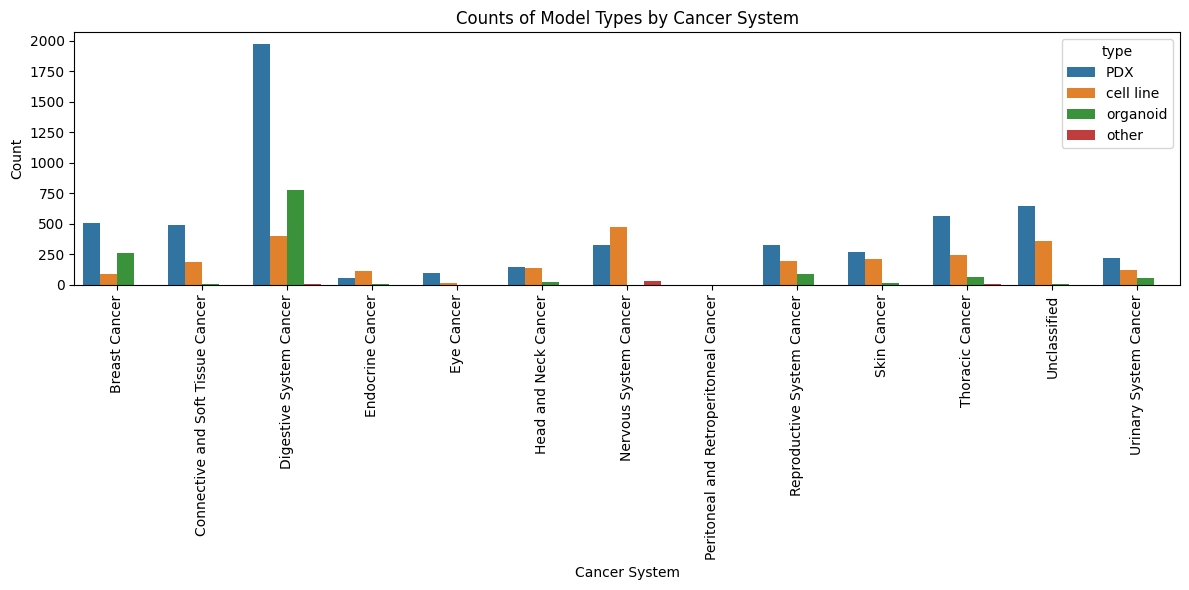

In [ ]:
melted_df = model_metadata.pivot_table(index='cancer_system', columns='type',  aggfunc='size', fill_value=0).reset_index().melt(id_vars='cancer_system', var_name='type', value_name='count')

# Create the bar plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='cancer_system', y='count', hue='type')

# Set labels and title
plt.xlabel('Cancer System')
plt.ylabel('Count')
plt.title('Counts of Model Types by Cancer System')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

### Molecular data distribution

<ipython-input-8-c5134d94cfec>:12: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  sns.barplot(data=grouped_df, x='type', y='count', hue='data_type', palette=sns.mpl_palette('Dark2'))


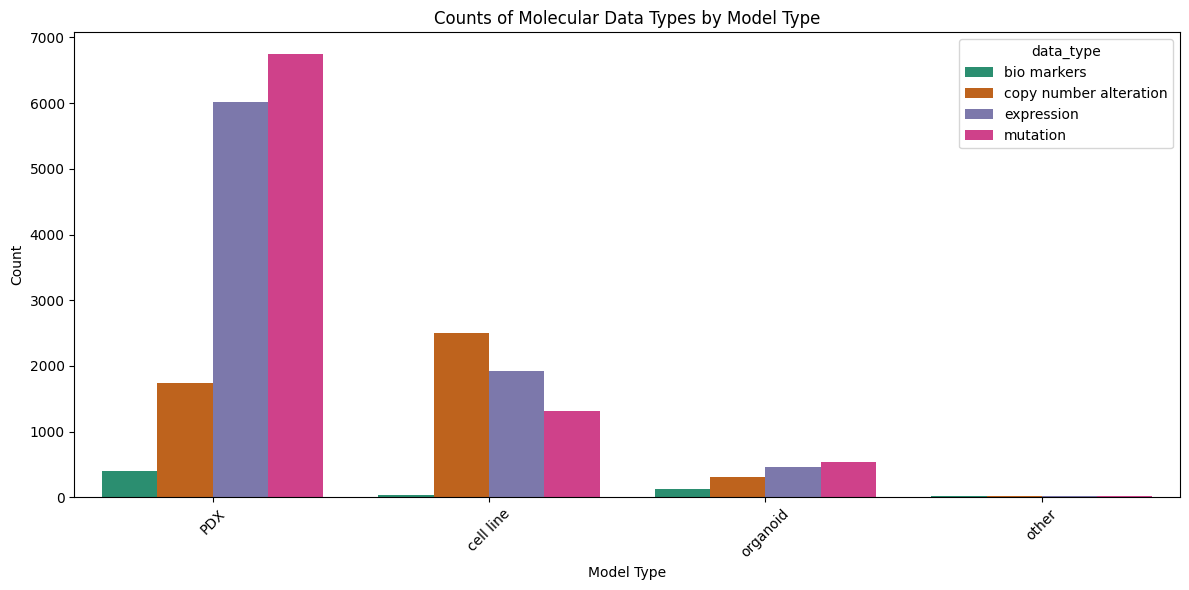

In [ ]:
# Load model molecular metadata
model_molecular_metadata = pd.read_json(f"{api_path}model_molecular_metadata")

# Merge model molecular metadata with model metadata on 'model_id'
merged_df = pd.merge(model_molecular_metadata, model_metadata, on='model_id')

# Group by 'type' (from model_metadata) and 'data_type' (from molecular data), and count occurrences
grouped_df = merged_df.groupby(['type', 'data_type']).size().reset_index(name='count')

# Plot the data using seaborn barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_df, x='type', y='count', hue='data_type', palette=sns.mpl_palette('Dark2'))

# Set labels and title
plt.xlabel('Model Type')
plt.ylabel('Count')
plt.title('Counts of Molecular Data Types by Model Type')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

## Analyse Breast Cancer Biomarkers

### Expression data analysis

In [ ]:
gene_set = ["BRCA1", "BRCA2", "ESR1", "PGR", "ERBB2"]
brca_normal = pd.read_csv('https://raw.githubusercontent.com/Mandloi2309/data-repo-organoid23/main/TCGA/tcga_brca_normal_fpkm.tsv', sep='\t')
normal = brca_normal[brca_normal['gene_symbol'].isin(gene_set)].reset_index(drop=True).rename(columns={'gene_symbol': 'hgnc_symbol'})
breast_cancer_models_in_cm = list(model_metadata[model_metadata['cancer_system']=='Breast Cancer']['model_id'])

In [ ]:
exp = {}
for gene in tqdm(gene_set):
  exp[gene] = get_gene_expression(gene, breast_cancer_models_in_cm)

100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


#### Boxplot
##### Notes
###### What is a T-Test?
A T-test is a statistical test used to compare the means (averages) of two groups and determine if the differences between them are statistically significant. In other words, it helps us determine whether the observed difference is due to chance or reflects a real difference between the groups.

###### Why Use a T-Test in the Boxplot Comparison?
In the context of comparing normal and tumor samples:

Goal: We want to know whether the difference in the RNA-Seq FPKM values (gene expression levels) between normal and tumor groups is statistically significant.
Assumption: If the difference between the two groups' means is large and unlikely to have occurred by chance, we can conclude that the two groups differ significantly in gene expression.
The T-test compares:

- The mean (average expression) of the normal group.
- The mean of the tumor group.

It accounts for:

- The variance within each group (how spread out the values are).
- The sample size of each group.


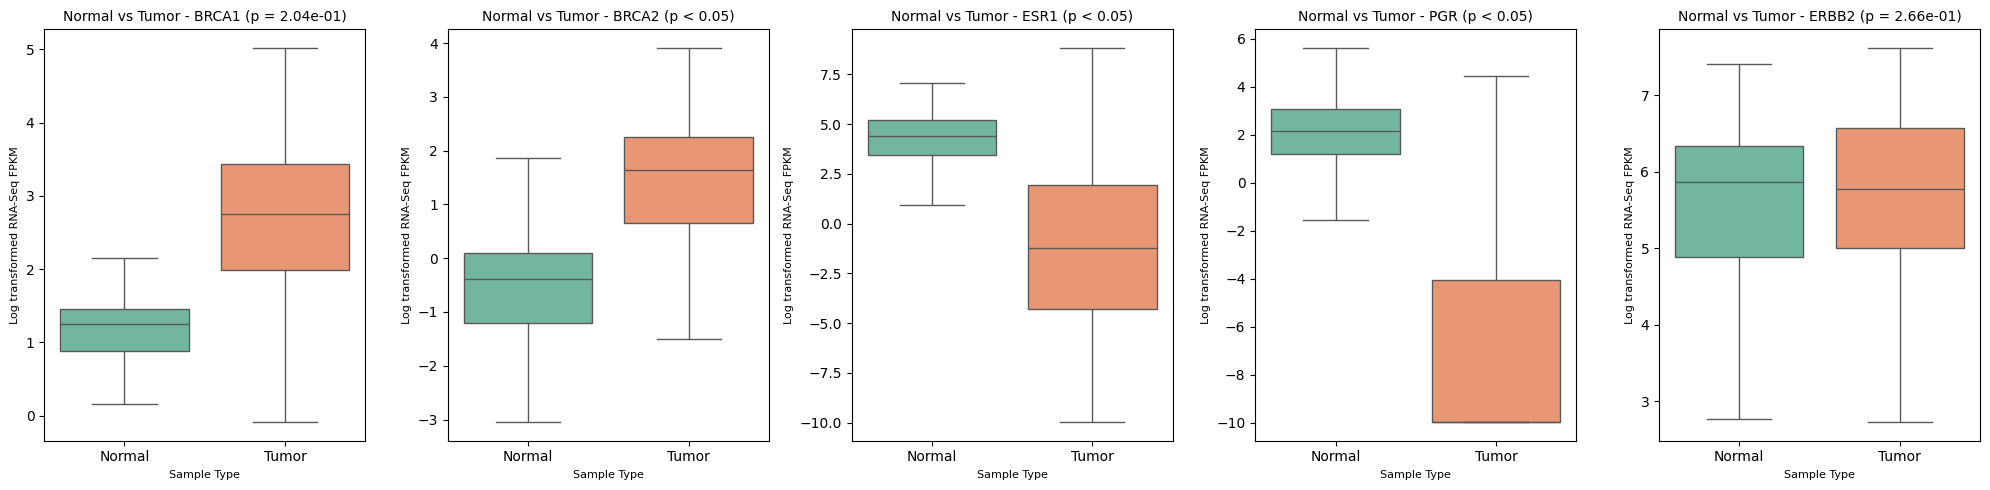

In [ ]:
# Create a row of subplots
fig, axes = plt.subplots(1, len(gene_set), figsize=(20, 5))  # 1 row, len(genes) columns

# Loop through each gene and create a boxplot
for i, gene in enumerate(gene_set):
    make_boxplot(normal, gene, exp[gene], axes[i])  # Pass each subplot axis to make_boxplot

plt.tight_layout()
plt.show()

##### Box plots based on the model type

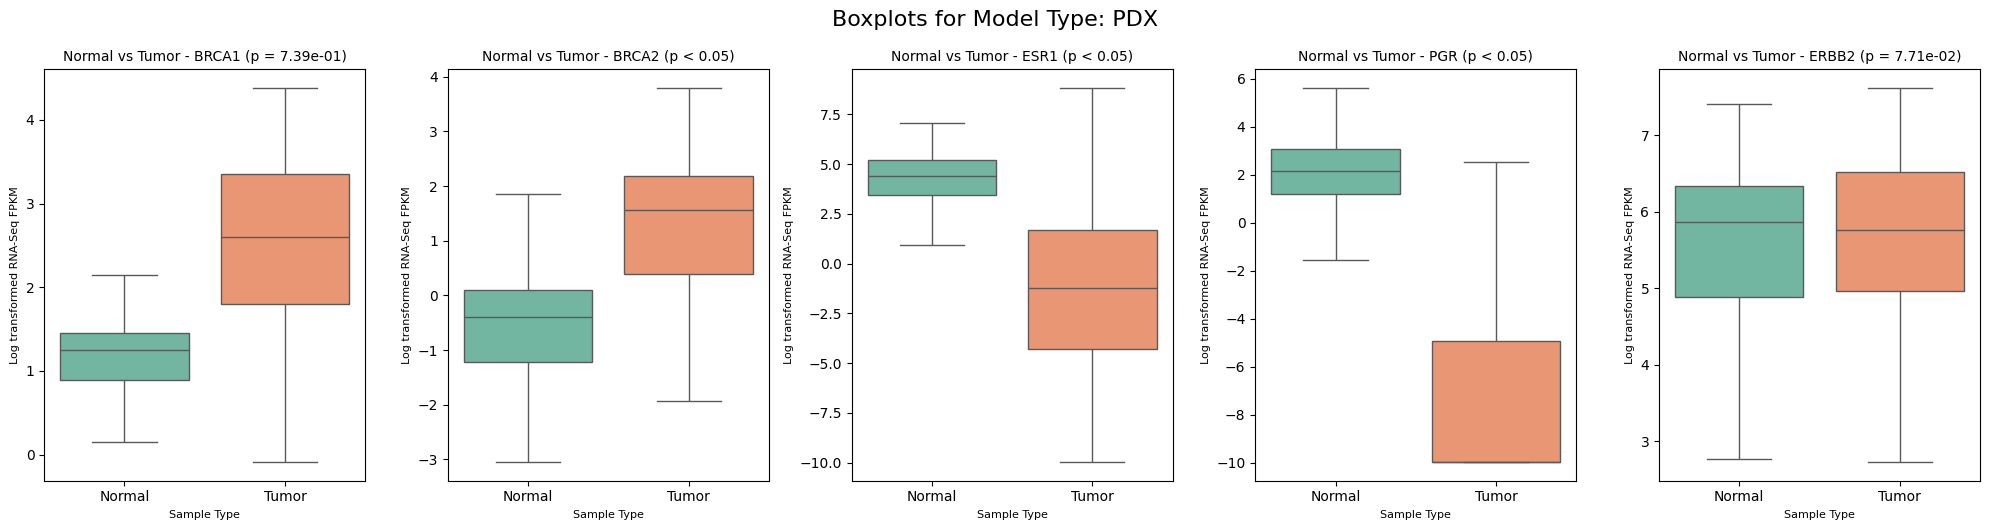

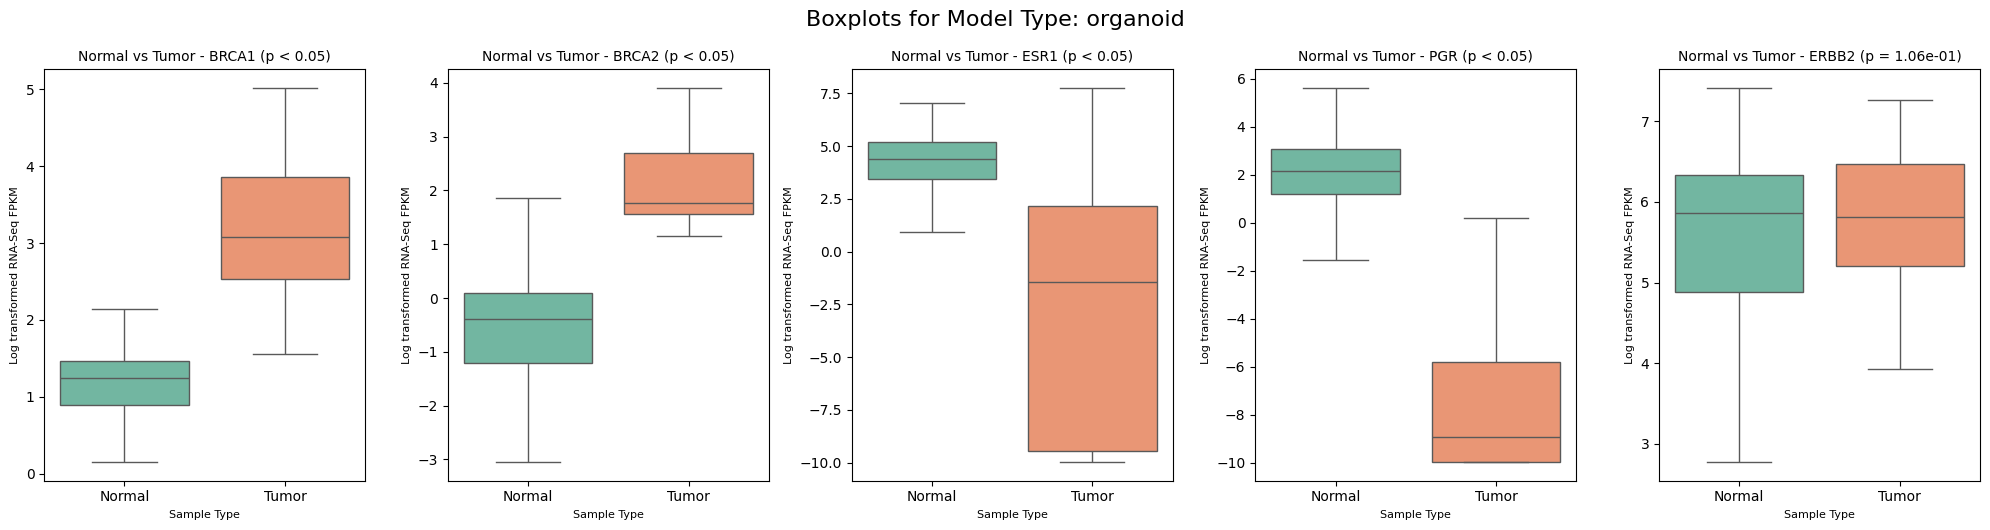

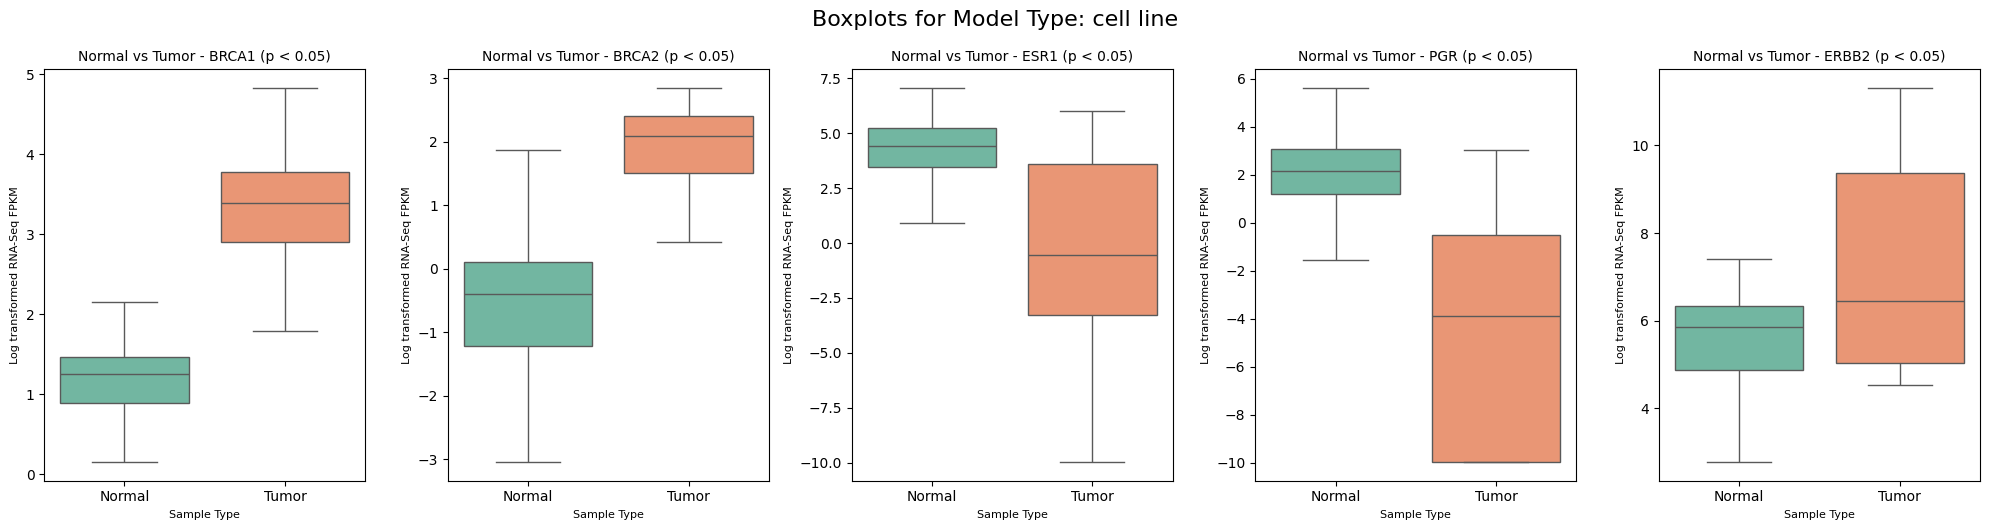

In [ ]:
model_types = model_metadata[['model_id', 'type']]

for types in ['PDX', 'organoid',  'cell line']:
  temp = model_types[model_types.type == types]

  # Create a row of subplots
  fig, axes = plt.subplots(1, len(gene_set), figsize=(20, 5))  # 1 row, len(genes) columns

  # Loop through each gene and create a boxplot
  for i, gene in enumerate(gene_set):

    expression_model_type = exp[gene].merge(temp, on='model_id', how='left')
    expression_model_type = expression_model_type[expression_model_type['type'] == types]
    make_boxplot(normal, gene, expression_model_type, axes[i])  # Pass each subplot axis to make_boxplot

  plt.tight_layout()
  plt.suptitle(f'Boxplots for Model Type: {types}', fontsize=16, y=1.05)  # Set an overall title for the figure
  plt.show()

#### Heatmap

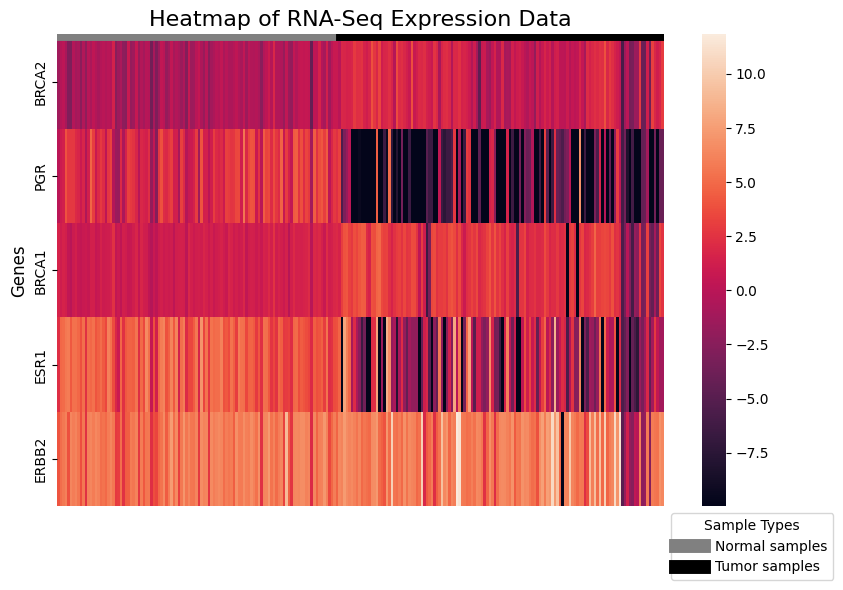

In [ ]:
pivot_exp = {}
for gene in gene_set:
  pivot_exp[gene] = exp[gene].pivot_table(columns='model_id', values='rnaseq_fpkm', index='hgnc_symbol')
expression_data_table = pd.concat(pivot_exp.values()).reset_index()
merged = normal.merge(expression_data_table, on='hgnc_symbol').set_index('hgnc_symbol')
heatmap_data = merged
plt.figure(figsize=(10, 6))
ax = plt.gca()
line_position = 0
ax.axhline(line_position, color='grey', linestyle='-', linewidth=10, xmax=normal.shape[1]/merged.shape[1], label='Normal samples')
ax.axhline(line_position, color='black', linestyle='-', linewidth=10, xmin=normal.shape[1]/merged.shape[1], label='Tumor samples')

sns.heatmap(heatmap_data, xticklabels=False)
plt.title('Heatmap of RNA-Seq Expression Data', fontsize=16)
plt.ylabel('Genes', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0), title='Sample Types')  # Change (1, 1) to your preferred position
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for legend
plt.show()
plt.show()

### Mutation data analysis

In [ ]:
mut = {}
for gene in tqdm(gene_set):
  mut[gene] = get_mutation_data(gene, breast_cancer_models_in_cm)

100%|██████████| 5/5 [02:58<00:00, 35.63s/it]


In [ ]:
mutation_all_gene_df = pd.DataFrame()
for gene in gene_set:
  mutation_all_gene_df = pd.concat([mutation_all_gene_df, mut[gene]])
mutation_all_gene_df = mutation_all_gene_df.merge(model_types, on='model_id', how='left')
mutation_all_gene_df.head()

,model_id,sample_id,hgnc_symbol,amino_acid_change,consequence,allele_frequency,ref_allele,alt_allele,type
0,128162-247-R,128162-247-R-AL-NQ6,BRCA1,Q172X,frameshift_variant,1.0,GT,G,PDX
1,128162-247-R,128162-247-R-AL-NQ6_AL-T93,BRCA1,Q172X,frameshift_variant,0.9951,GT,G,PDX
2,128162-247-R,128162-247-R-AL-NQ6_AL-T93_AL-W64,BRCA1,Q172X,frameshift_variant,0.9958,GT,G,PDX
3,128162-247-R,128162-247-R-AL-NQ7_AL-U52,BRCA1,Q172X,frameshift_variant,0.9956,GT,G,PDX
4,128162-247-R,128162-247-R-AL-NQ9,BRCA1,Q172X,frameshift_variant,1.0,GT,G,PDX


#### Bar Plot of Mutation Frequency by Gene

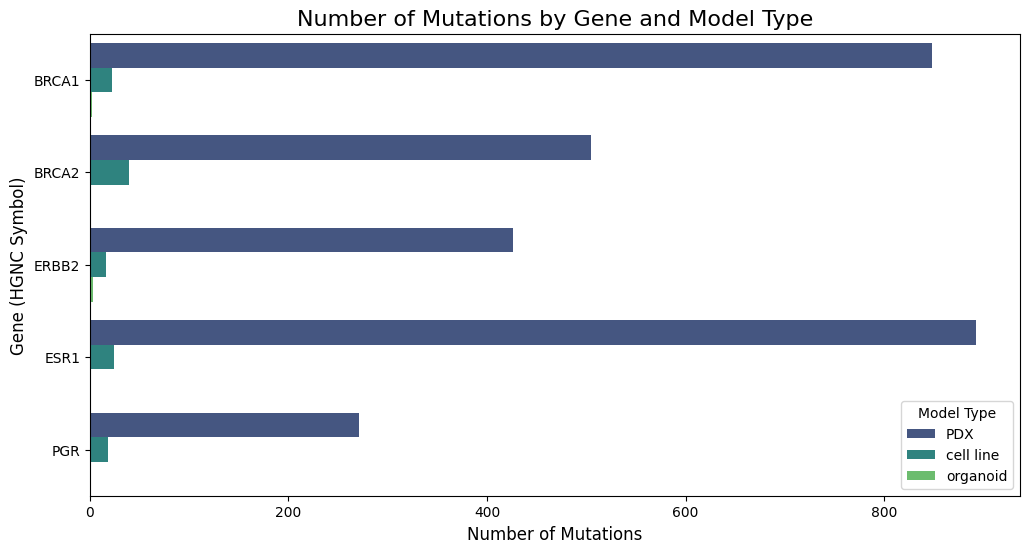

In [ ]:
# Calculate mutation counts by gene and model type
mutation_counts = mutation_all_gene_df.groupby(['hgnc_symbol', 'type']).size().reset_index(name='mutation_count')

# Create a bar plot with hue for model type
plt.figure(figsize=(12, 6))
sns.barplot(x='mutation_count', y='hgnc_symbol', data=mutation_counts, hue='type', palette='viridis')

# Customize the plot
plt.title('Number of Mutations by Gene and Model Type', fontsize=16)
plt.xlabel('Number of Mutations', fontsize=12)
plt.ylabel('Gene (HGNC Symbol)', fontsize=12)
plt.legend(title='Model Type', fontsize=10)  # Optional: Customize legend title and size
plt.show()

#### Pie Chart of Mutation Consequences

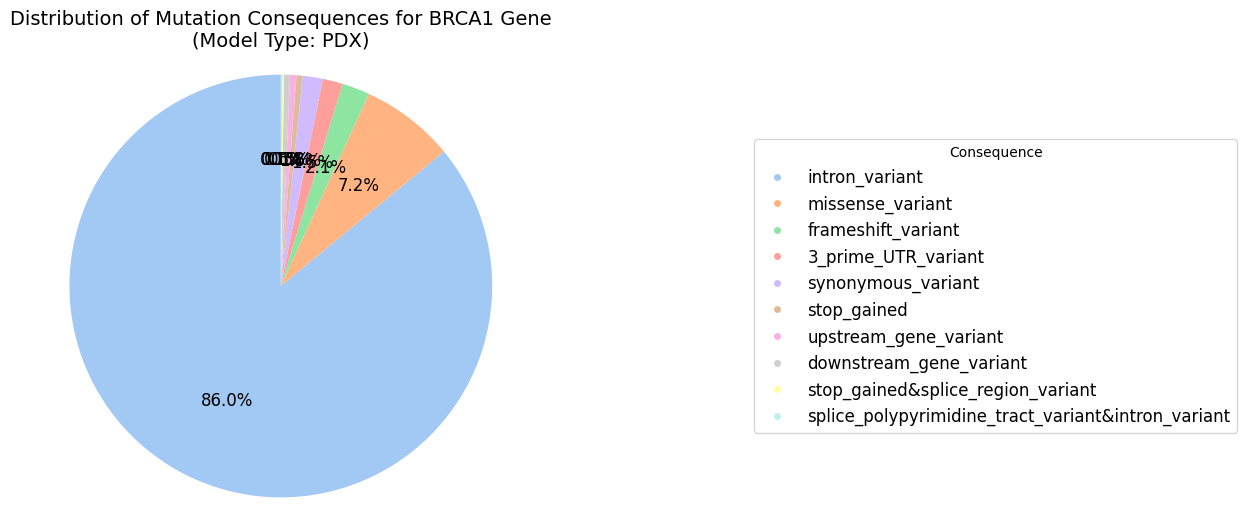

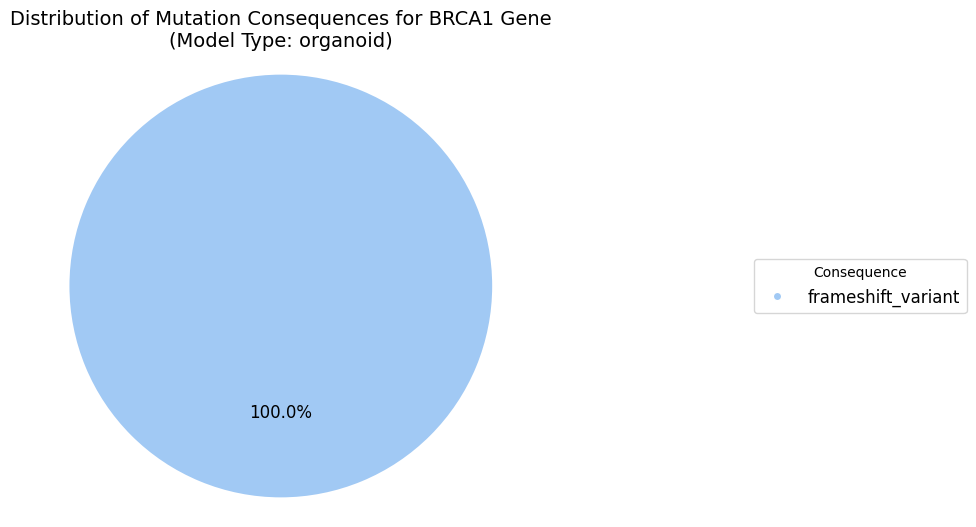

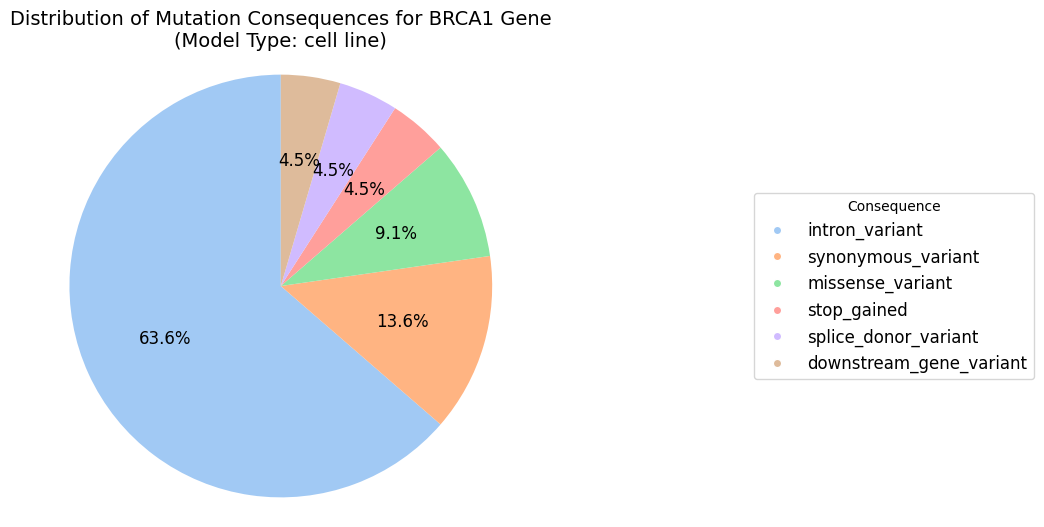

In [ ]:
mut_brca = mutation_all_gene_df[mutation_all_gene_df['hgnc_symbol'] == 'BRCA1']
mt = mut_brca['type'].unique()
colors = sns.color_palette('pastel', len(mut_brca['consequence'].unique()))

# Loop through each model type and create a pie chart for the mutation consequences
for model_type in mt:
    # Filter the DataFrame for the current model type
    consequence_counts = mut_brca[mut_brca['type'] == model_type]['consequence'].value_counts()

    # Create a new figure for each model type
    plt.figure(figsize=(6, 6))

    # Create a pie chart with percentages
    wedges, texts, autotexts = plt.pie(consequence_counts, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(f'Distribution of Mutation Consequences for BRCA1 Gene\n(Model Type: {model_type})', fontsize=14)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

    # Style the percentage labels
    for text in autotexts:
        text.set_color('black')  # Change text color for visibility
        text.set_fontsize(12)    # Set font size for better readability

    # Create a common legend outside of the plot
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=consequence,
                           markerfacecolor=colors[i]) for i, consequence in enumerate(consequence_counts.index)]

    # Add the legend outside the plot
    plt.legend(handles=handles, title='Consequence', loc='center left', fontsize=12, bbox_to_anchor=(1.5, 0.5))
    plt.show()

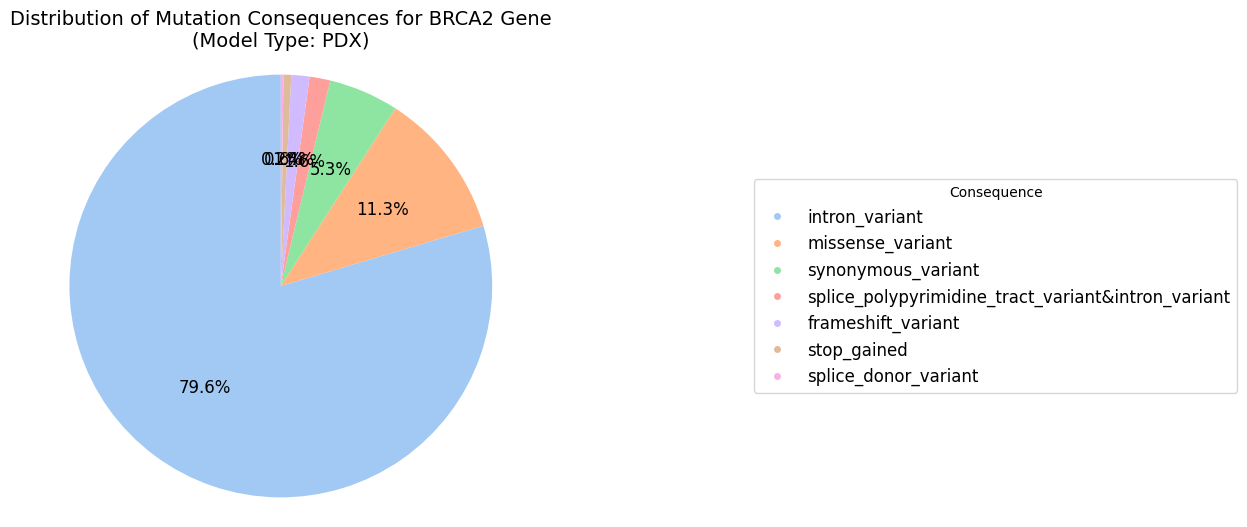

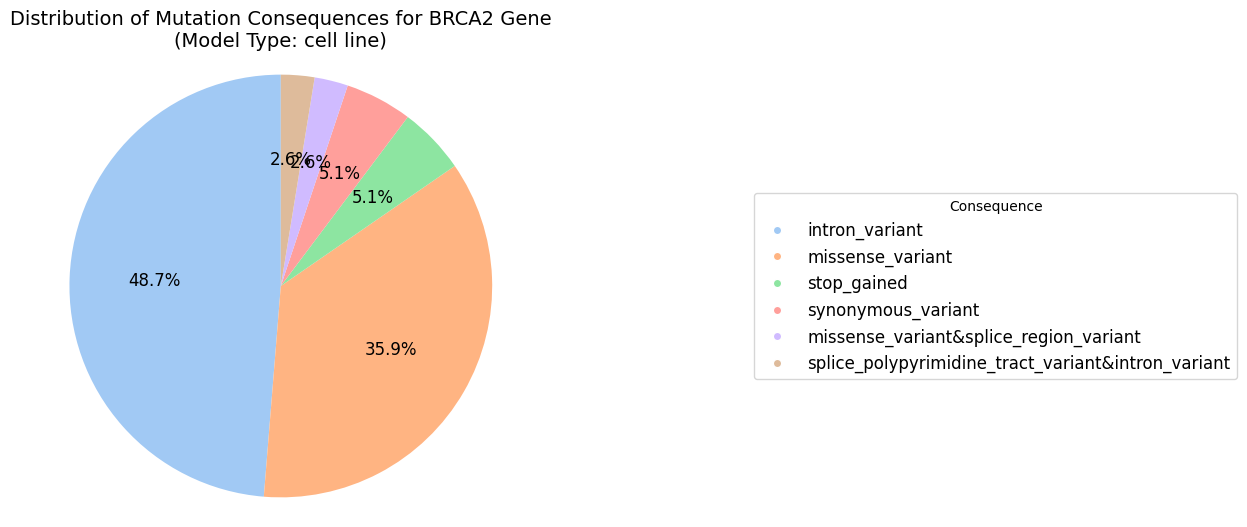

In [ ]:
mut_brca = mutation_all_gene_df[mutation_all_gene_df['hgnc_symbol'] == 'BRCA2']
mt = mut_brca['type'].unique()
colors = sns.color_palette('pastel', len(mut_brca['consequence'].unique()))

# Loop through each model type and create a pie chart for the mutation consequences
for model_type in mt:
    # Filter the DataFrame for the current model type
    consequence_counts = mut_brca[mut_brca['type'] == model_type]['consequence'].value_counts()

    # Create a new figure for each model type
    plt.figure(figsize=(6, 6))

    # Create a pie chart with percentages
    wedges, texts, autotexts = plt.pie(consequence_counts, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(f'Distribution of Mutation Consequences for BRCA2 Gene\n(Model Type: {model_type})', fontsize=14)
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

    # Style the percentage labels
    for text in autotexts:
        text.set_color('black')  # Change text color for visibility
        text.set_fontsize(12)    # Set font size for better readability

    # Create a common legend outside of the plot
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=consequence,
                           markerfacecolor=colors[i]) for i, consequence in enumerate(consequence_counts.index)]

    # Add the legend outside the plot
    plt.legend(handles=handles, title='Consequence', loc='center left', fontsize=12, bbox_to_anchor=(1.5, 0.5))
    plt.show()

#### Allele frequency

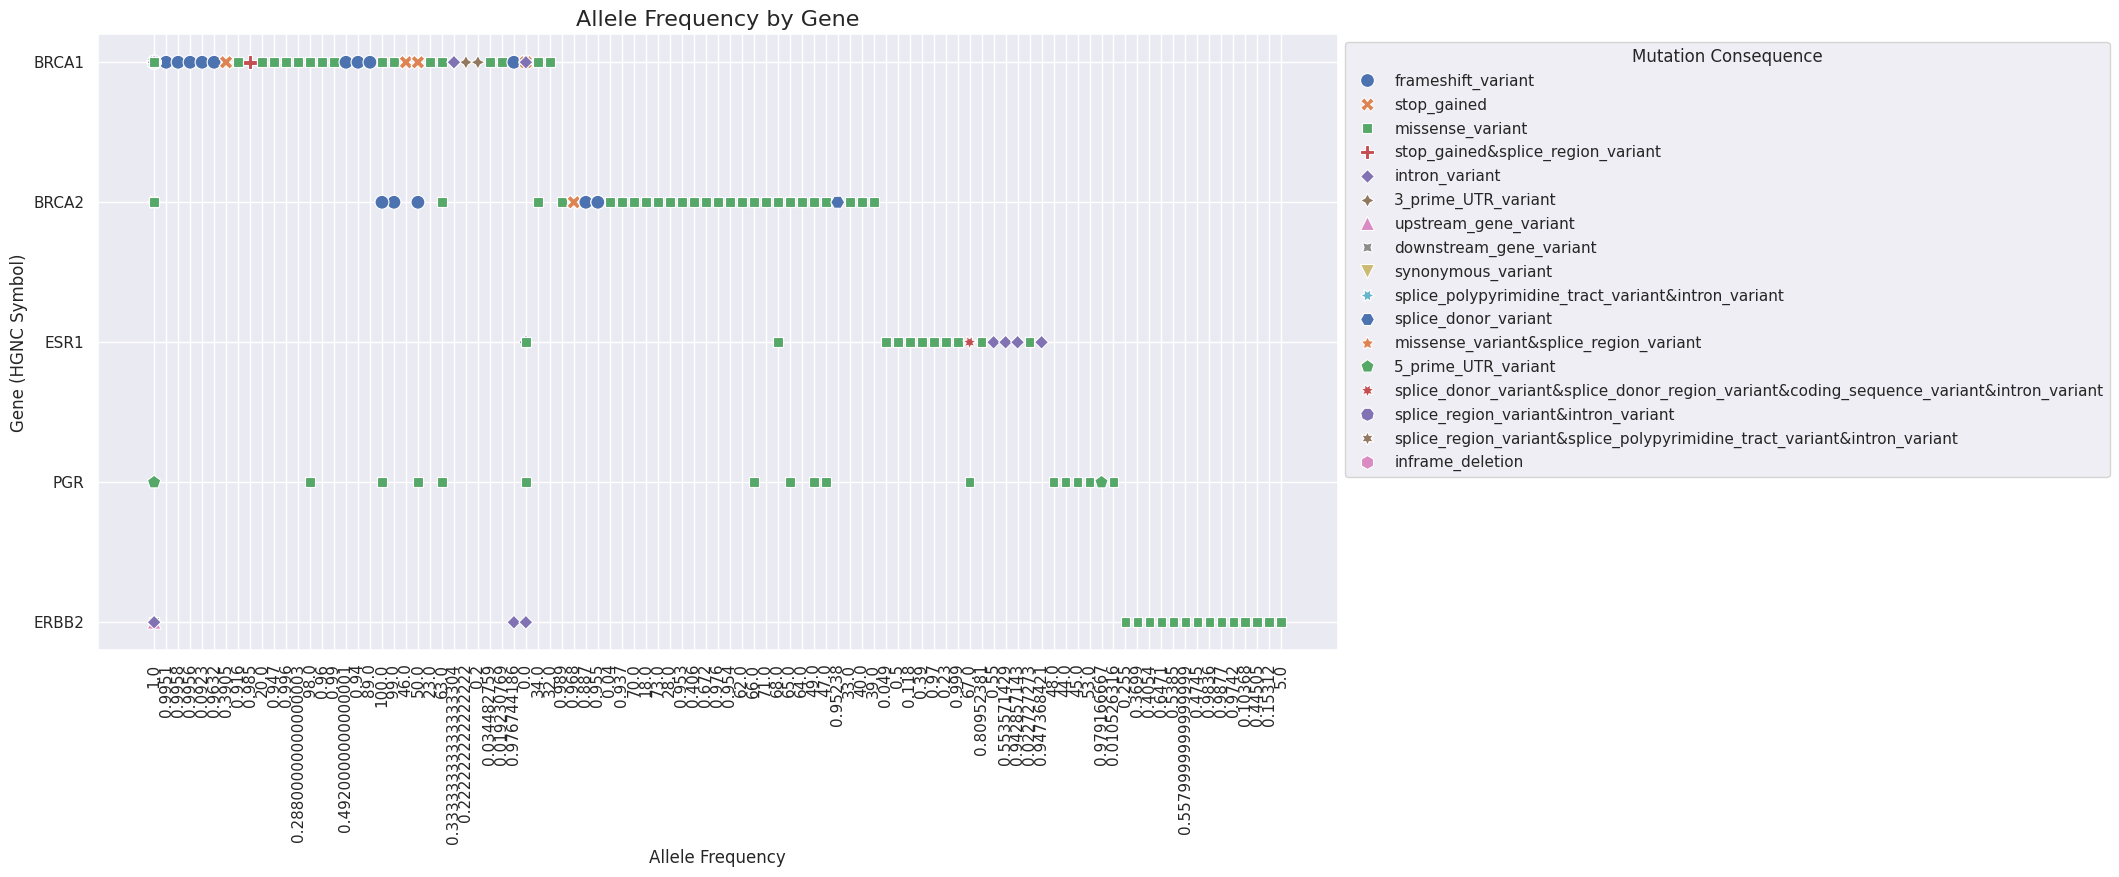

In [ ]:
plt.figure(figsize=(16, 8))
sns.scatterplot(data=mutation_all_gene_df, x='allele_frequency', y='hgnc_symbol', hue='consequence', style='consequence', s=100, palette='deep')
plt.title('Allele Frequency by Gene', fontsize=16)
plt.xlabel('Allele Frequency', fontsize=12)
plt.ylabel('Gene (HGNC Symbol)', fontsize=12)
plt.legend(title='Mutation Consequence', bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
#plt.legend(handles=handles, title='Consequence', loc='center left', fontsize=12, )
plt.show()

## Biomarker across cancer systems

#### KRAS expression across cacner systems

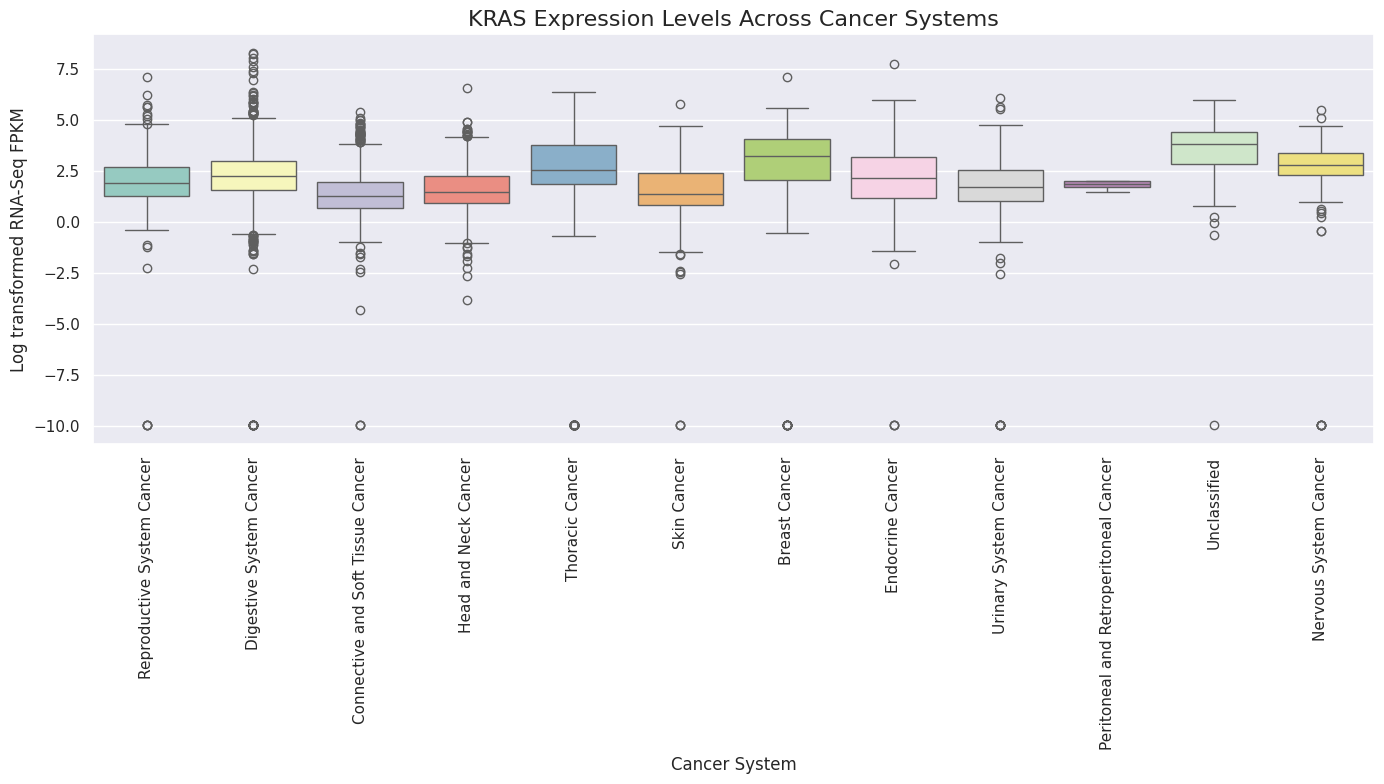

In [ ]:
plot_cancer_system_boxplot('KRAS', model_metadata)

#### EGFR expression across cancer systems

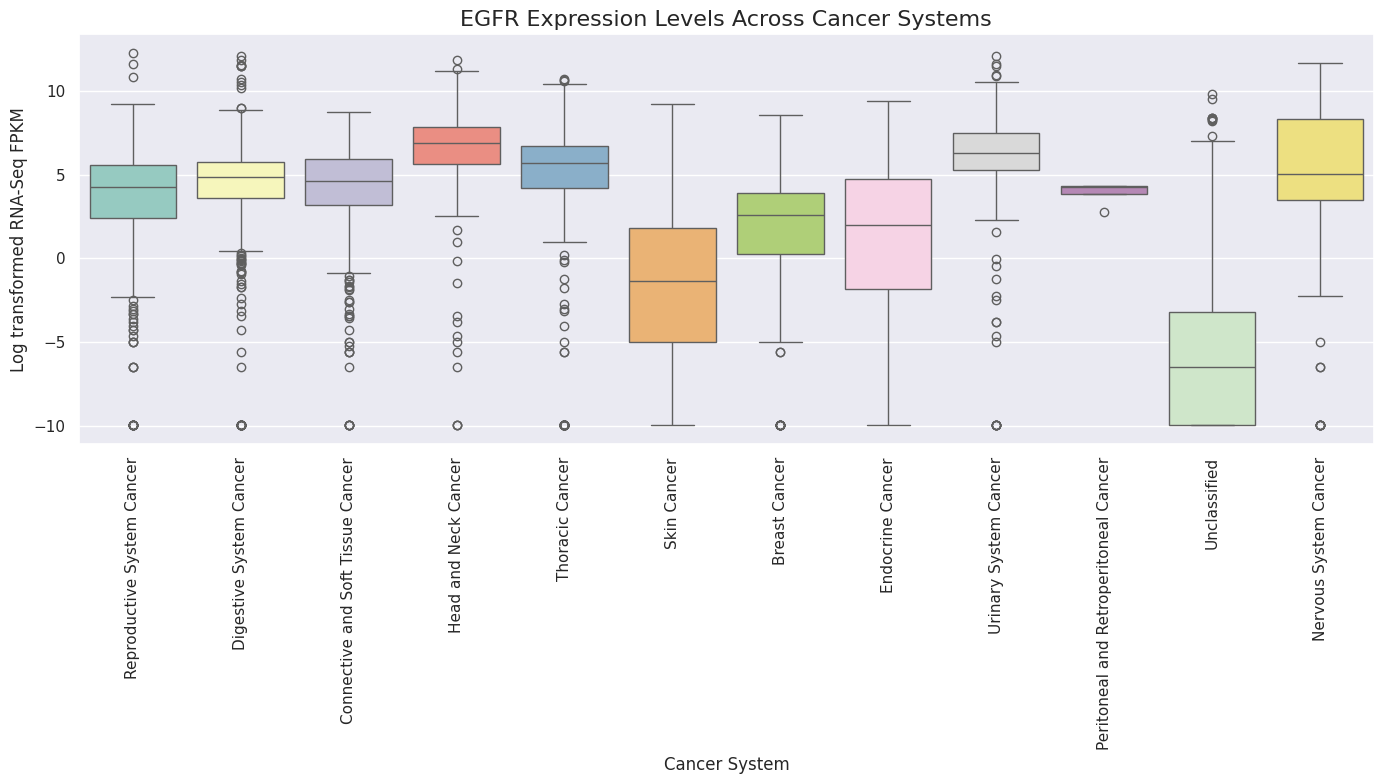

In [ ]:
plot_cancer_system_boxplot('EGFR', model_metadata)

#### MYC expression levels across cancer system based on model type

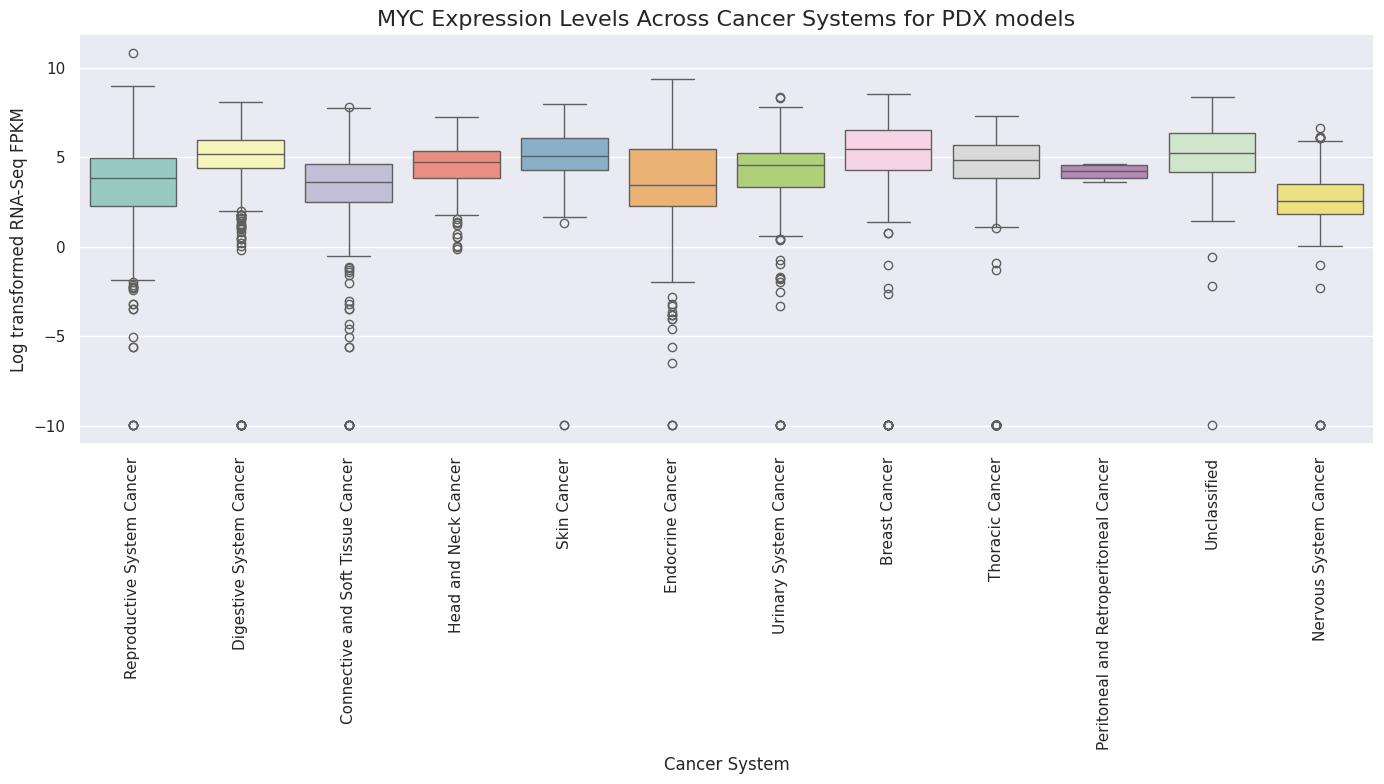

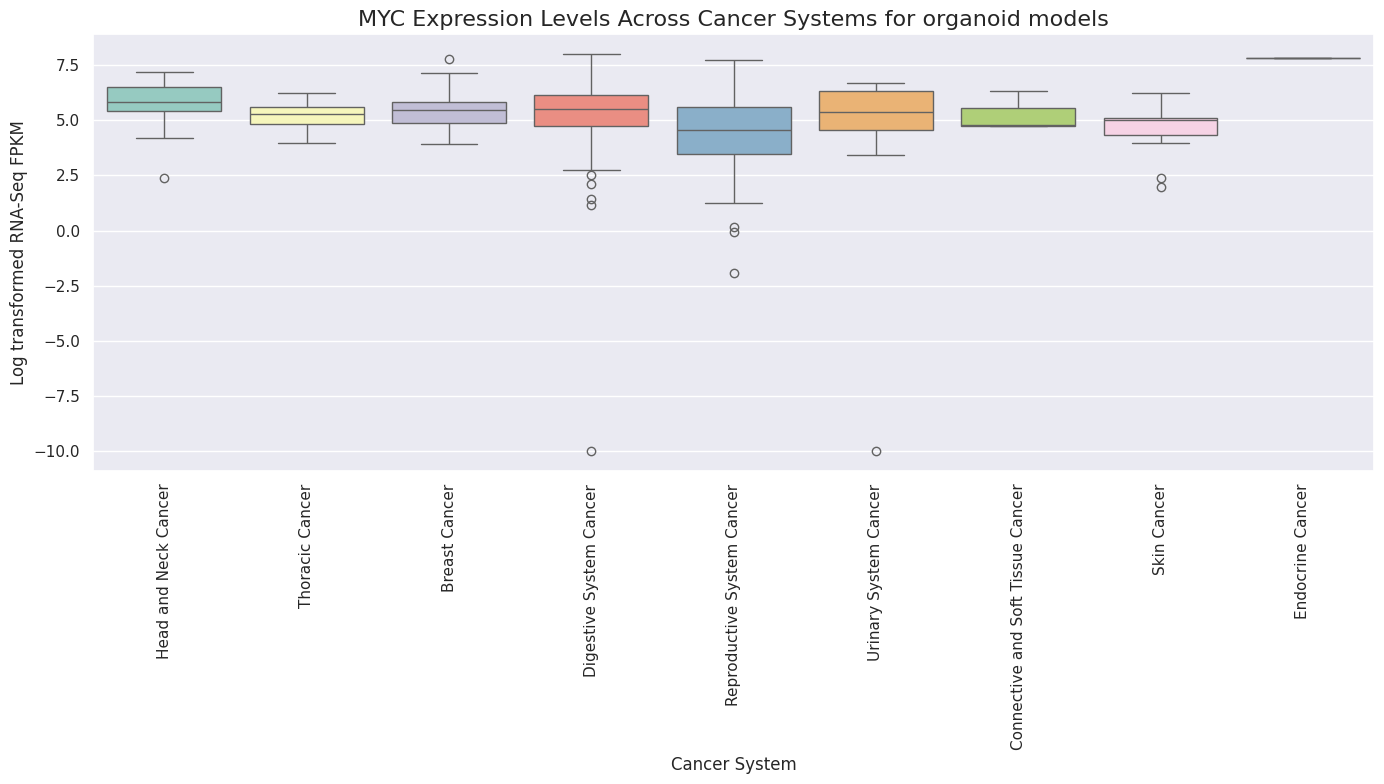

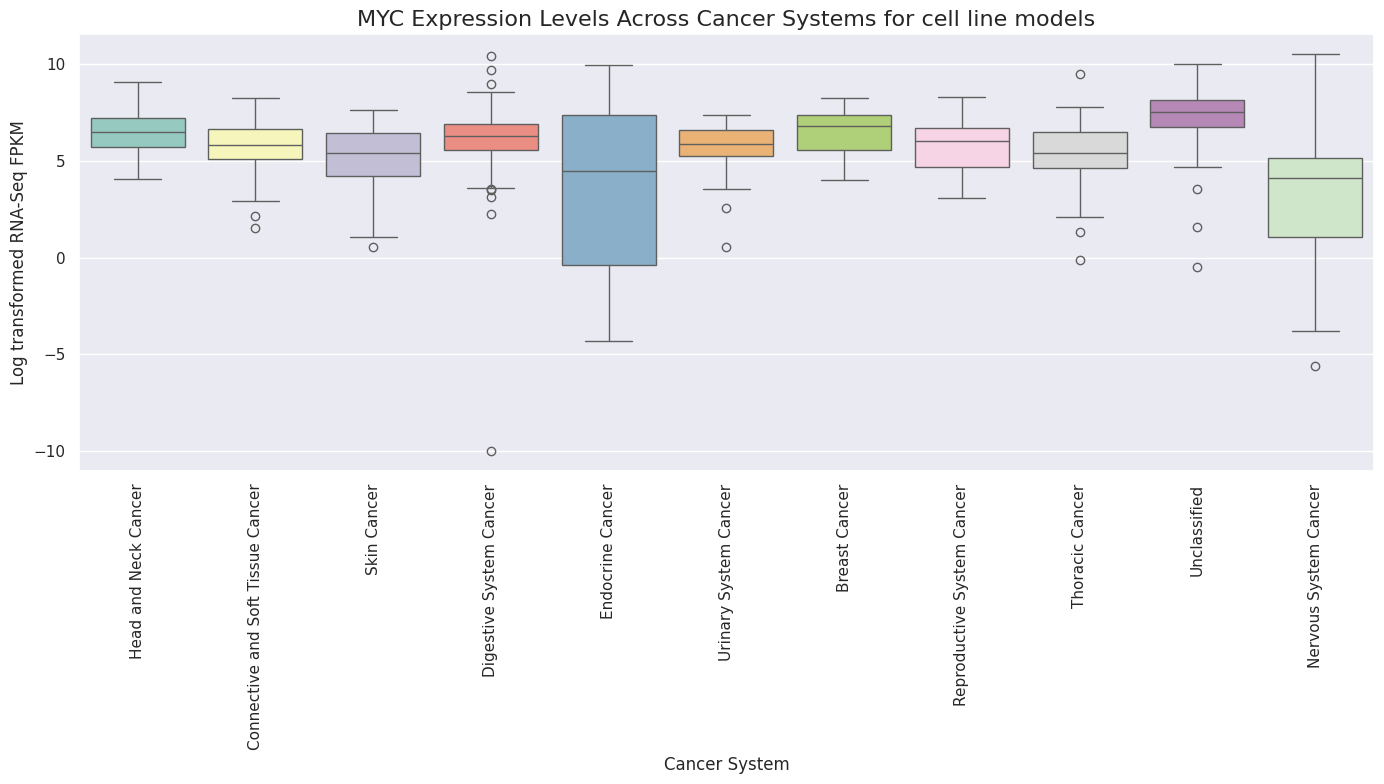

In [ ]:
plot_cancer_system_boxplot_by_model_type('MYC', model_metadata)